In [6]:
import numpy as np
from matplotlib import pyplot as plt
import sys 
sys.path.append("../Algorithms/")
from random_svd import randomized_svd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Video
from time import time
from tqdm import tqdm


## Load in and prepare image

In [2]:
color = plt.imread('panda.png')
# convert to grayscale
R = color[:, :, 0]
G = color[:, :, 1]
B = color[:, :, 2]
image = (0.299 * R) + (0.587 * G) + (0.114 * B)

# normalize the image
image = image / np.max(image)

# calculate true SVD for comparison
U_true, S_true, Vt_true = np.linalg.svd(image, full_matrices=False)

In [3]:
image.shape

(2856, 4290)

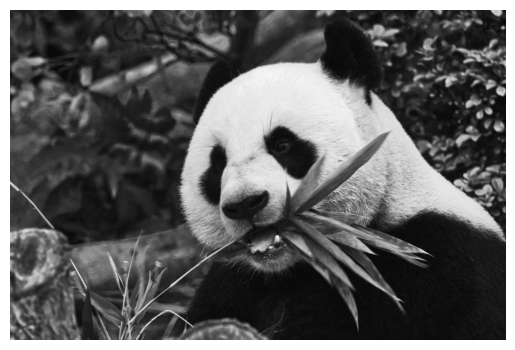

In [4]:
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

Trunc Computation Time:  2.809730052947998
RSVD Computation Time:  0.15469002723693848


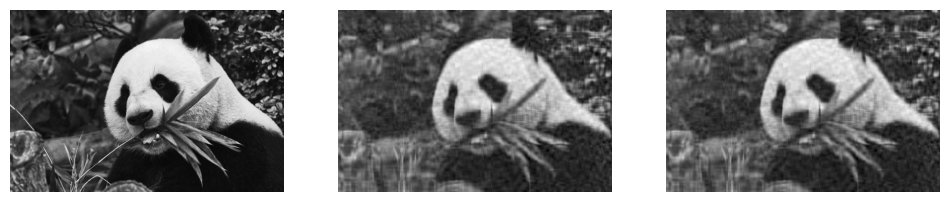

In [63]:
plt.figure(figsize=(12,10))

k = 25
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
start = time()
U, S, Vt = np.linalg.svd(image, full_matrices=True)
reconstructed_image = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :] 
print("Trunc Computation Time: ", time() - start)
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
start = time()
U, S, Vt = randomized_svd(image, k=k, r=2, q=2, range_method='subspace_iter')
reconstructed_image = U @ np.diag(S) @ Vt
print("RSVD Computation Time: ", time() - start)
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')
plt.show()

## Error Analysis

In [ ]:
# Compare truncated SVD and randomized SVD errors and computation time
errors_trunc = []
errors_rand = []
abs_errors_trunc = []
abs_errors_rand = []
time_rand = []
time_trunc = []
for k in tqdm(range(1, 2000, 50)):
    # Truncated SVD
    start_trunc = time()
    U_true, S_true, Vt_true = np.linalg.svd(image, full_matrices=False)
    U_trunc = U_true[:, :k]
    S_trunc = S_true[:k]
    Vt_trunc = Vt_true[:k, :]
    trunc_reconstructed_image = U_trunc @ np.diag(S_trunc) @ Vt_trunc
    end_trunc = time()
    time_trunc.append(end_trunc - start_trunc)
    trunc_error = np.linalg.norm(image - trunc_reconstructed_image, 'fro')/np.linalg.norm(image, 'fro')
    errors_trunc.append(trunc_error)
    abs_trunc_error = np.linalg.norm(image - trunc_reconstructed_image, 'fro')
    abs_errors_trunc.append(abs_trunc_error)
    start_rand = time()
    # Randomized SVD
    U, S, Vt = randomized_svd(image, k=k, oversamples=10, r=2, q=0, range_method='subspace_iter')
    random_reconstructed_image = U @ np.diag(S) @ Vt
    end_rand = time()
    time_rand.append(end_rand - start_rand)
    rand_error = np.linalg.norm(image - random_reconstructed_image, 'fro')/np.linalg.norm(image, 'fro')
    errors_rand.append(rand_error)
    abs_rand_error = np.linalg.norm(image - random_reconstructed_image, 'fro')
    abs_errors_rand.append(abs_rand_error)


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [02:32<00:00,  3.82s/it]


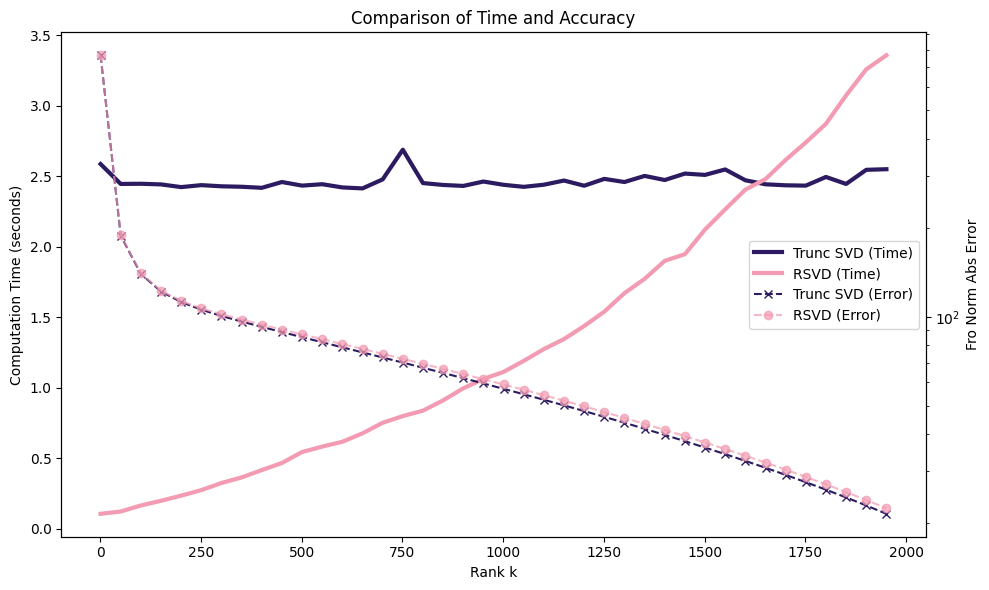

In [22]:
# Plot time vs. absolute error for both methods
k_values = range(1, 2000, 50)

fig, ax1 = plt.subplots(figsize=(10, 6))
color_trunc = '#2d1b61' 
color_rand = '#f39bb2'  

ax1.set_xlabel('Rank k')
ax1.set_ylabel('Computation Time (seconds)')

# time lines
lns1 = ax1.plot(k_values, time_trunc, color=color_trunc, linestyle='-', linewidth=3, label='Trunc SVD (Time)')
lns2 = ax1.plot(k_values, time_rand, color=color_rand, linestyle='-', linewidth=3, label='RSVD (Time)')

ax2 = ax1.twinx() 
ax2.set_ylabel('Fro Norm Abs Error')

# error lines 
lns3 = ax2.semilogy(k_values, abs_errors_trunc, color=color_trunc, linestyle='--', marker='x', label='Trunc SVD (Error)')
lns4 = ax2.semilogy(k_values, abs_errors_rand, color=color_rand, linestyle='--', marker='o', alpha=0.7, label='RSVD (Error)')


lns = lns1 + lns2 + lns3 + lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

plt.title('Comparison of Time and Accuracy')
plt.tight_layout()
plt.show()

In [53]:
U, S, Vt = randomized_svd(image, k=20, r=3, q=2, range_method='subspace_iter') 
print(abs(S-S_true[:20]))

[6.03988613e-05 2.44900605e-07 1.48442598e-06 1.48824385e-05
 6.66462302e-06 6.67638082e-06 2.78632913e-06 2.60094731e-06
 1.52404863e-06 1.34606020e-06 3.44855482e-06 7.75979458e-08
 7.42353720e-07 3.55492176e-07 1.61921339e-06 5.76796396e-07
 1.69582890e-06 1.83843258e-06 4.39629643e-06 2.01916626e-05]


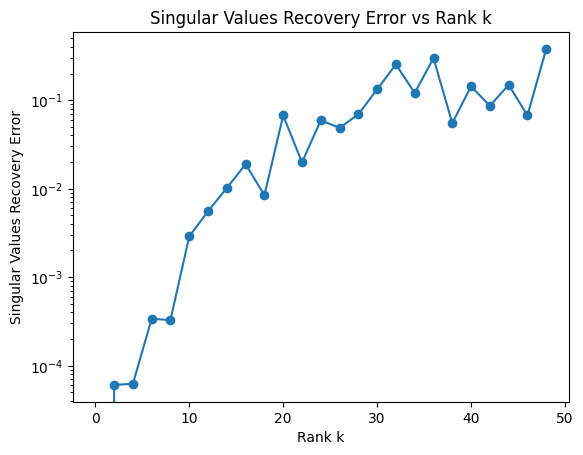

In [47]:
# verify singular values recovery with default oversampling and power iterations
norms = []
ks = np.arange(0, 50, 2)
for k in ks:
    U, S, Vt = randomized_svd(image, k=k, oversamples=10, r=2, q=2, range_method='subspace_iter')   
    sigs = S[:k]
    norms.append(np.linalg.norm(S_true[:k] - sigs))
plt.semilogy(ks, norms, 'o-')
plt.xlabel('Rank k')
plt.ylabel('Singular Values Recovery Error')
plt.title('Singular Values Recovery Error vs Rank k')
plt.show()

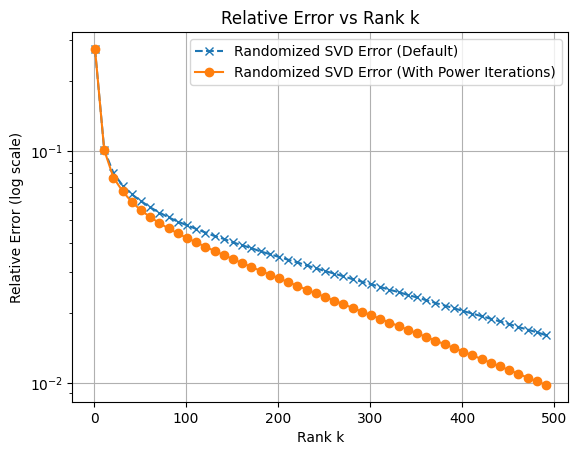

In [ ]:


ks = np.arange(1, 2000 + 1, 50)
# visualize relative error for both methods of orhogonalization
errors_rand = []
errors_randq = []
for k in tqdm(ks):
    U,S,Vt = randomized_svd(image, k, range_method="qr")
    err_rand = np.linalg.norm(image - U @ np.diag(S) @ Vt, 'fro')/np.linalg.norm(image, 'fro')
    U,S,Vt = randomized_svd(image, k, r = 3,range_method="subspace_iter")
    err_randq = np.linalg.norm(image - U @ np.diag(S) @ Vt, 'fro')/np.linalg.norm(image, 'fro')
    errors_trunc.append(err_rand)
    errors_rand.append(err_randq)

plt.semilogy(ks, errors_trunc, 'x--', label='RSVD Error (QR)')
plt.semilogy(ks, errors_rand, 'o-', label='RSVD Error (Subspace Iter)')
plt.xlabel('Rank k')
plt.ylabel('Relative Error (log scale)')
plt.title('Relative Error vs Rank k')
plt.legend()
plt.grid()
plt.show()


100%|██████████| 40/40 [04:47<00:00,  7.20s/it]


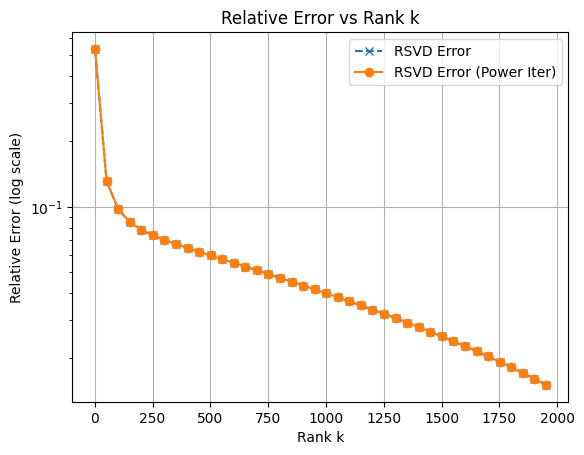

In [61]:


ks = np.arange(1, 2000 + 1, 50)
errors_rand = []
errors_randq = []
for k in tqdm(ks):
    U,S,Vt = randomized_svd(image, k, q=0, range_method="subspace_iter")
    err_rand = np.linalg.norm(image - U @ np.diag(S) @ Vt, 'fro')/np.linalg.norm(image, 'fro')
    U,S,Vt = randomized_svd(image, k, q=2, range_method="subspace_iter")
    err_randq = np.linalg.norm(image - U @ np.diag(S) @ Vt, 'fro')/np.linalg.norm(image, 'fro')
    errors_rand.append(err_rand)
    errors_randq.append(err_randq)
plt.semilogy(ks, errors_rand, 'x--', label='RSVD Error')
plt.semilogy(ks, errors_randq, 'o-', label='RSVD Error (Power Iter)')
plt.xlabel('Rank k')
plt.ylabel('Relative Error (log scale)')
plt.title('Relative Error vs Rank k')
plt.legend()
plt.grid()
plt.show()
